In [1]:
# fmt: off
import urllib
from IPython.display import Markdown as md

### change to reflect your notebook
_nb_loc = "06_preprocessing/06a_resizing.ipynb"
_nb_title = "Preprocessing for resizing"

_icons=["https://raw.githubusercontent.com/GoogleCloudPlatform/practical-ml-vision-book/master/logo-cloud.png", "https://www.tensorflow.org/images/colab_logo_32px.png", "https://www.tensorflow.org/images/GitHub-Mark-32px.png", "https://www.tensorflow.org/images/download_logo_32px.png"]
_links=["https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?" + urllib.parse.urlencode({"name": _nb_title, "download_url": "https://github.com/takumiohym/practical-ml-vision-book-ja/raw/master/"+_nb_loc}), "https://colab.research.google.com/github/takumiohym/practical-ml-vision-book-ja/blob/master/{0}".format(_nb_loc), "https://github.com/takumiohym/practical-ml-vision-book-ja/blob/master/{0}".format(_nb_loc), "https://raw.githubusercontent.com/takumiohym/practical-ml-vision-book-ja/master/{0}".format(_nb_loc)]
md("""<table class="tfo-notebook-buttons" align="left"><td><a target="_blank" href="{0}"><img src="{4}"/>Run in Vertex AI Workbench</a></td><td><a target="_blank" href="{1}"><img src="{5}" />Run in Google Colab</a></td><td><a target="_blank" href="{2}"><img src="{6}" />View source on GitHub</a></td><td><a href="{3}"><img src="{7}" />Download notebook</a></td></table><br/><br/>""".format(_links[0], _links[1], _links[2], _links[3], _icons[0], _icons[1], _icons[2], _icons[3]))
# fmt: on

<table class="tfo-notebook-buttons" align="left"><td><a target="_blank" href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?name=Preprocessing+for+resizing&download_url=https%3A%2F%2Fgithub.com%2Ftakumiohym%2Fpractical-ml-vision-book-ja%2Fraw%2Fmaster%2F06_preprocessing%2F06a_resizing.ipynb"><img src="https://raw.githubusercontent.com/GoogleCloudPlatform/practical-ml-vision-book/master/logo-cloud.png"/>Run in Vertex AI Workbench</a></td><td><a target="_blank" href="https://colab.research.google.com/github/takumiohym/practical-ml-vision-book-ja/blob/master/06_preprocessing/06a_resizing.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a></td><td><a target="_blank" href="https://github.com/takumiohym/practical-ml-vision-book-ja/blob/master/06_preprocessing/06a_resizing.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a></td><td><a href="https://raw.githubusercontent.com/takumiohym/practical-ml-vision-book-ja/master/06_preprocessing/06a_resizing.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a></td></table><br/><br/>

# リサイジング、およびその他の前処理レイヤー
このノートブックでは、トレーニング済みの画像の埋め込みを使用して、tf-flowersデータセットを分類するニューラルネットワークを構築します。<br>
[第3章の転移学習ノートブック](../03_image_models/03a_transfer_learning.ipynb)とは、以下の２つの点が異なっています。

* JPEGファイルではなくTFRecordファイルを読み込む 
* 画像を読み込み時ではなく、モデル内でサイズ変更を実行する


## 実行環境
このノートブックは、TPUまたはGPUで実行するように設定されています。GPUでは実行に時間がかかるため、特にTPUでの実行を推奨しています。

Vertex AI WorkbenchやColabでTPUを使用する方法については[実行環境のセットアップ
](https://github.com/takumiohym/practical-ml-vision-book-ja/tree/main/environment_setup)を参照してください。

## TPUまたはGPUの検出

In [ ]:
import tensorflow as tf

try: # detect TPUs
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError: # detect GPUs or multi-GPU machines
    strategy = tf.distribute.MirroredStrategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

In [3]:
# Helper functions
def training_plot(metrics, history):
    f, ax = plt.subplots(1, len(metrics), figsize=(5*len(metrics), 5))
    for idx, metric in enumerate(metrics):
        ax[idx].plot(history.history[metric], ls='dashed')
        ax[idx].set_xlabel("Epochs")
        ax[idx].set_ylabel(metric)
        ax[idx].plot(history.history['val_' + metric]);
        ax[idx].legend([metric, 'val_' + metric])

In [5]:
import matplotlib.pylab as plt
import numpy as np

IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_CHANNELS = 3
CLASS_NAMES = 'daisy dandelion roses sunflowers tulips'.split()

## TFRecordsの読み込み

(240, 320, 3)
tf.Tensor(0.35263795, shape=(), dtype=float32)
tf.Tensor(4, shape=(), dtype=int64)
(213, 320, 3)
tf.Tensor(0.69847876, shape=(), dtype=float32)
tf.Tensor(4, shape=(), dtype=int64)
(240, 320, 3)
tf.Tensor(0.22729652, shape=(), dtype=float32)
tf.Tensor(4, shape=(), dtype=int64)
(333, 500, 3)
tf.Tensor(0.27678332, shape=(), dtype=float32)
tf.Tensor(4, shape=(), dtype=int64)
(240, 320, 3)
tf.Tensor(0.39305508, shape=(), dtype=float32)
tf.Tensor(1, shape=(), dtype=int64)


2022-07-11 16:02:05.265794: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: INVALID_ARGUMENT: Unable to find the relevant tensor remote_handle: Op ID: 43, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1657555325.262408110","description":"Error received from peer ipv4:10.112.92.178:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 43, Output num: 0","grpc_status":3}


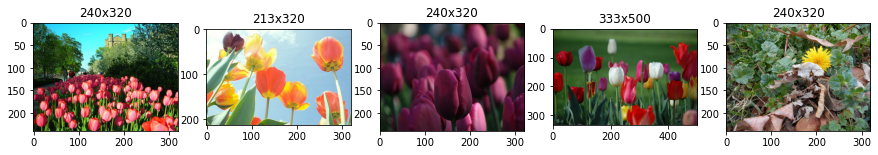

In [6]:
def parse_tfr(proto):
    feature_description = {
        'image': tf.io.VarLenFeature(tf.float32),
        'shape': tf.io.VarLenFeature(tf.int64),
        'label': tf.io.FixedLenFeature([], tf.string, default_value=''),
        'label_int': tf.io.FixedLenFeature([], tf.int64, default_value=0),
    }
    rec = tf.io.parse_single_example(
        proto, feature_description
    )
    shape = tf.sparse.to_dense(rec['shape'])
    img = tf.reshape(tf.sparse.to_dense(rec['image']), shape)
    label_int = rec['label_int']
    return img, label_int

train_dataset = tf.data.TFRecordDataset(
    [filename for filename in tf.io.gfile.glob(
        'gs://practical-ml-vision-book-data/flowers_tfr/train-*')
    ], compression_type='GZIP').map(parse_tfr)

f, ax = plt.subplots(1, 5, figsize=(15,15))
for idx, (img, label_int) in enumerate(train_dataset.take(5)):
    print(img.shape)
    mean_of_image = tf.reduce_mean(img)
    print(mean_of_image)
    print(label_int)
    ax[idx].imshow((img.numpy()));
    ax[idx].set_title('{}x{}'.format(img.shape[0], img.shape[1]))

## リサイジング

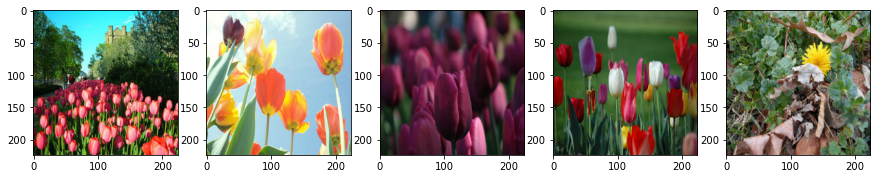

In [7]:
preproc_layers = tf.keras.Sequential([
    tf.keras.layers.Resizing(
        height=IMG_HEIGHT, width=IMG_WIDTH,
        input_shape=(None, None, 3))
    ])

def apply_preproc(img, label):
    # add to a batch, call preproc, remove from batch
    x = tf.expand_dims(img, 0)
    x = preproc_layers(x)
    x = tf.squeeze(x, 0)
    return x, label

f, ax = plt.subplots(1, 5, figsize=(15,15))
for idx, (img, label_int) in enumerate(train_dataset.map(apply_preproc).take(5)):
    ax[idx].imshow((img.numpy()));

## リサイジング + パディング

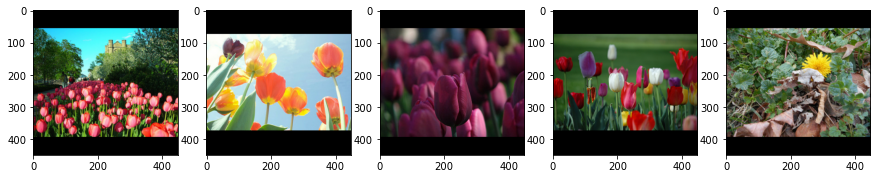

In [8]:
def apply_preproc(img, label):
    return tf.image.resize_with_pad(img, 2*IMG_HEIGHT, 2*IMG_WIDTH), label

f, ax = plt.subplots(1, 5, figsize=(15,15))
for idx, (img, label_int) in enumerate(train_dataset.map(apply_preproc).take(5)):
    ax[idx].imshow((img.numpy()));

## リサイジング + パディング + センタークロップ

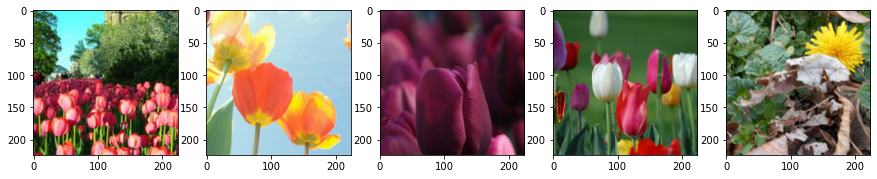

In [9]:
preproc_layers = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda img:
                           tf.image.resize_with_pad(
                               img, 2*IMG_HEIGHT, 2*IMG_WIDTH),
                           input_shape=(None, None, 3)),
    tf.keras.layers.CenterCrop(
        height=IMG_HEIGHT, width=IMG_WIDTH)
    ])

def apply_preproc(img, label):
    # add to a batch, call preproc, remove from batch
    x = tf.expand_dims(img, 0)
    x = preproc_layers(x)
    x = tf.squeeze(x, 0)
    return x, label

f, ax = plt.subplots(1, 5, figsize=(15,15))
for idx, (img, label_int) in enumerate(train_dataset.map(apply_preproc).take(5)):
    ax[idx].imshow((img.numpy()));

## MobileNetによる転移学習  

事前にトレーニングされたモデルをロードして、最初のレイヤーとしてFlattenedレイヤーの代わりに使用してみましょう。

In [20]:
import tensorflow_hub as hub
import os

os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'UNCOMPRESSED'

preproc_layers = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda img:
                           tf.image.resize_with_pad(
                               img, 2*IMG_HEIGHT, 2*IMG_WIDTH),
                           input_shape=(None, None, 3)),
    tf.keras.layers.CenterCrop(
        height=IMG_HEIGHT, width=IMG_WIDTH)
    ])

def apply_preproc(img, label):
    # add to a batch, call preproc, remove from batch
    x = tf.expand_dims(img, 0)
    x = preproc_layers(x)
    x = tf.squeeze(x, 0)
    return x, label

# parameterize to the values in the previous cell
def train_and_evaluate(batch_size = 32,
                       lrate = 0.001,
                       l1 = 0.,
                       l2 = 0.,
                       num_hidden = 16):
  regularizer = tf.keras.regularizers.l1_l2(l1, l2)

  train_dataset = tf.data.TFRecordDataset(
    [filename for filename in tf.io.gfile.glob(
        'gs://practical-ml-vision-book-data/flowers_tfr/train-*')
    ],
    compression_type='GZIP'
  ).map(parse_tfr).map(apply_preproc).batch(batch_size)

  eval_dataset = tf.data.TFRecordDataset(
    [filename for filename in tf.io.gfile.glob(
        'gs://practical-ml-vision-book-data/flowers_tfr/valid-*')
    ],
    compression_type='GZIP'
  ).map(parse_tfr).map(apply_preproc).batch(batch_size)

  layers = [
      hub.KerasLayer(
          "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4",
          input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),
          trainable=False,
          name='mobilenet_embedding'),
      tf.keras.layers.Dense(num_hidden,
                            kernel_regularizer=regularizer, 
                            activation=tf.keras.activations.relu,
                            name='dense_hidden'),
      tf.keras.layers.Dense(len(CLASS_NAMES), 
                            kernel_regularizer=regularizer,
                            activation='softmax',
                            name='flower_prob')
  ]

  model = tf.keras.Sequential(layers, name='flower_classification')
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lrate),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(
                    from_logits=False),
                metrics=['accuracy'])
  print(model.summary())
  history = model.fit(train_dataset, validation_data=eval_dataset, epochs=10)
  training_plot(['loss', 'accuracy'], history)
  return model

Model: "flower_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_embedding (KerasL  (None, 1280)             2257984   
 ayer)                                                           
                                                                 
 dense_hidden (Dense)        (None, 16)                20496     
                                                                 
 flower_prob (Dense)         (None, 5)                 85        
                                                                 
Total params: 2,278,565
Trainable params: 20,581
Non-trainable params: 2,257,984
_________________________________________________________________
None
Epoch 1/10
92/92 [==============================] - 49s 496ms/step - loss: 0.8161 - accuracy: 0.6973 - val_loss: 0.5387 - val_accuracy: 0.7979
Epoch 2/10


2022-07-11 16:11:24.340618: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: INVALID_ARGUMENT: Unable to find the relevant tensor remote_handle: Op ID: 4540, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1657555884.340479295","description":"Error received from peer ipv4:10.112.92.178:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 4540, Output num: 0","grpc_status":3}


92/92 [==============================] - 20s 211ms/step - loss: 0.3891 - accuracy: 0.8691 - val_loss: 0.4149 - val_accuracy: 0.8394
Epoch 3/10
92/92 [==============================] - 20s 211ms/step - loss: 0.2691 - accuracy: 0.9107 - val_loss: 0.3805 - val_accuracy: 0.8549
Epoch 4/10
92/92 [==============================] - 19s 207ms/step - loss: 0.2076 - accuracy: 0.9349 - val_loss: 0.3633 - val_accuracy: 0.8601
Epoch 5/10
92/92 [==============================] - 20s 210ms/step - loss: 0.1652 - accuracy: 0.9536 - val_loss: 0.3604 - val_accuracy: 0.8523
Epoch 6/10
92/92 [==============================] - 19s 209ms/step - loss: 0.1341 - accuracy: 0.9652 - val_loss: 0.3690 - val_accuracy: 0.8523
Epoch 7/10
92/92 [==============================] - 19s 209ms/step - loss: 0.1094 - accuracy: 0.9727 - val_loss: 0.3763 - val_accuracy: 0.8549
Epoch 8/10
92/92 [==============================] - 19s 208ms/step - loss: 0.0896 - accuracy: 0.9802 - val_loss: 0.3886 - val_accuracy: 0.8446
Epoch 9/10

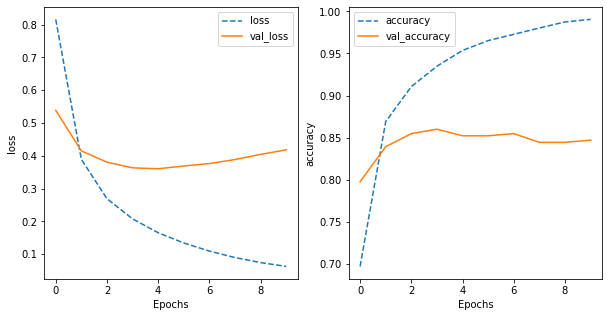

In [21]:
model = train_and_evaluate()

2022-07-11 16:20:10.009454: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: INVALID_ARGUMENT: Unable to find the relevant tensor remote_handle: Op ID: 10566, Output num: 1
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1657556410.009352111","description":"Error received from peer ipv4:10.112.92.178:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 10566, Output num: 1","grpc_status":3}


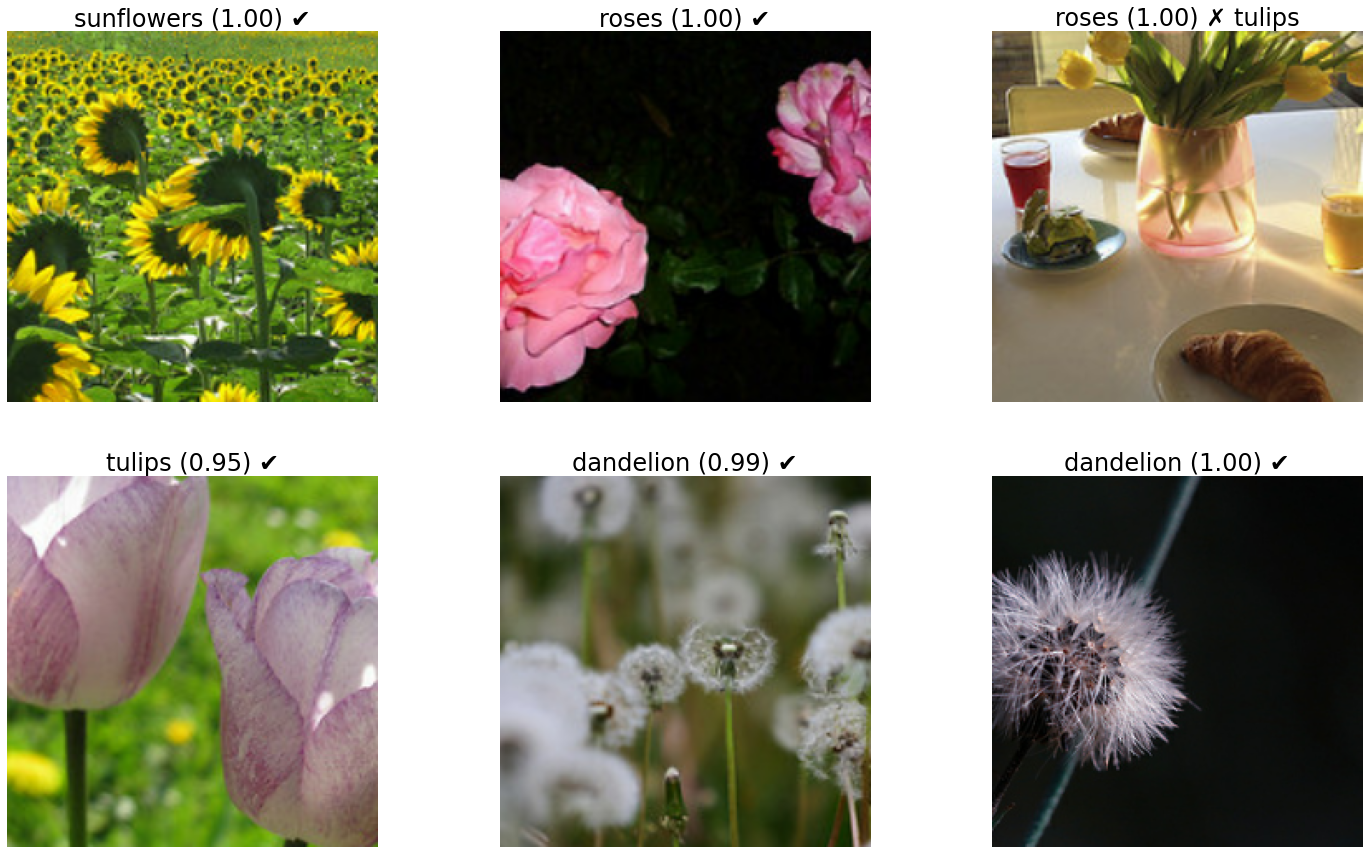

In [22]:
# Call model.predict() on a few images in the evaluation dataset
def plot_predictions(model, pattern):
  dataset = tf.data.TFRecordDataset(
      [filename for filename in tf.io.gfile.glob(
        pattern)
      ],
      compression_type='GZIP'
  ).map(parse_tfr).map(apply_preproc).shuffle(100)

  nrows, ncols = 2, 3;
  f, ax = plt.subplots(nrows, ncols, figsize=(25,15))
  for idx, (img, label) in enumerate(dataset.take(6)):
    ax[idx//ncols, idx%ncols].imshow((img.numpy()));
    batch_image = tf.reshape(img, [1, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS])
    batch_pred = model.predict(batch_image)
    pred = batch_pred[0]
    label = CLASS_NAMES[label.numpy()]
    pred_label_index = tf.math.argmax(pred).numpy()
    pred_label = CLASS_NAMES[pred_label_index]
    prob = pred[pred_label_index]
    ax[idx//ncols, idx%ncols].set_title('{} ({:.2f}) {}'.format( 
        pred_label, prob, 
        '\u2714' if (label == pred_label) else '\u2717 {}'.format(label)),
        fontsize=24)
    ax[idx//ncols, idx%ncols].axis('off')

plot_predictions(model, 'gs://practical-ml-vision-book-data/flowers_tfr/valid-*')

## License
Copyright 2022 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.